In [1]:
from utils.analysis.analyzer import *
import re
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/soumyajit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# file_paths = ["../../US_climate_change_policy.pdf", "../../National_sustainabilyt_mission.pdf", "../../UKEF_Climate_Change_Strategy_2021.pdf"]
# file_paths = ["../../National_sustainabilyt_mission.pdf"]
# file_paths = ["../../UKEF_Climate_Change_Strategy_2021.pdf"]
file_paths = ["../../US_climate_change_policy.pdf"]

documents = []
for file_path in file_paths:
    text = read_pdf(file_path, return_list=False)
    documents.append(text)

#### Model Building

In [4]:
sentences = sent_tokenize("\n\n".join(documents))
print(len(sentences))


929


In [5]:
# idx = 12
# len(sentences[idx].split())

sentences_ = []
for sentence in sentences:
    if len(sentence.split()) > 5 and not sentence.endswith("?"):
        sentences_.append(sentence)

print(len(sentences_))

782


In [6]:
docs = sentences_.copy()

import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')

# Split the documents into tokens, remove links and non-alphanumeric characters
import re
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

for idx in range(len(docs)):
    # Remove links
    docs[idx] = re.sub(r'http\S+|www.\S+', '', docs[idx])
    
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    
    # Remove non-alphanumeric characters and tokenize
    docs[idx] = tokenizer.tokenize(re.sub(r'\W', ' ', docs[idx]))

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

# Remove stopwords
docs = [[token for token in doc if token not in stopwords.words('english')] for doc in docs]

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/soumyajit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [8]:
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]


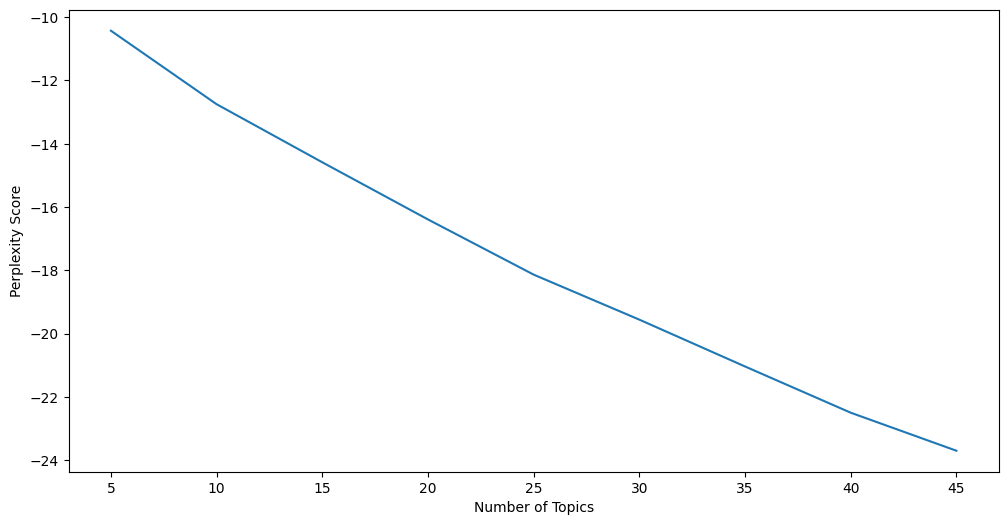

In [9]:
train_corpus = corpus[:int(len(corpus)*0.8)]
valid_corpus = corpus[int(len(corpus)*0.8):]

perplexity_values = []
num_topics_list = range(5, 50, 5)

for num_topics in num_topics_list:
    model = LdaModel(corpus=train_corpus, id2word=dictionary, num_topics=num_topics)
    perplexity_values.append(model.log_perplexity(valid_corpus))

plt.figure(figsize=(12, 6))
plt.plot(num_topics_list, perplexity_values)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.show()

In [10]:
model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=15)

In [11]:
def print_topics(topics):
    topics_ls = []
    for topic in topics:
        words = topic[1].split("+")
        topic_words = [word.split("*")[1].replace('"', '').strip() for word in words]
        topics_ls.append(topic_words)
    for i, topic in enumerate(topics_ls):
        print(f"Topic_{i+1}:", ' '.join(topic))

def get_topics(topics):
    topics_ls = []
    for topic in topics:
        words = topic[1].split("+")
        topic_words = [word.split("*")[1].replace('"', '').strip() for word in words]
        topics_ls.append(topic_words)
    return topics_ls

# def calculate_topic_similarity(topics):
#     similarity_scores = []
#     for i in range(len(topics)):
#         for j in range(i+1, len(topics)):
#             similarity_score = len(set(topics[i]).intersection(set(topics[j])))/len(set(topics[i]).union(set(topics[j])))
#             similarity_scores.append(similarity_score)
#     return similarity_scores

def calculate_topic_similarity_matrix(topics):
    n = len(topics)
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            if i == j:
                similarity_matrix[i][j] = 1.0
            else:
                similarity_score = len(set(topics[i]).intersection(set(topics[j]))) / len(set(topics[i]).union(set(topics[j])))
                similarity_matrix[i][j] = similarity_score
                similarity_matrix[j][i] = similarity_score
    
    return similarity_matrix

topics = model.print_topics(num_words=30)
topics_ = get_topics(model.print_topics(num_words=30))
print_topics(topics)
similarity_scores = calculate_topic_similarity_matrix(topics_)
print(len(topics_))
# topics
# for topic in topics:
#     print(f"Topic_{topic[0]}: {topic[1]}\n")


Topic_1: climate energy action ghg report see program standard change new emission international federal plan epa review development state related cr disclosure united news public information framework statement carbon technology vehicle
Topic_2: emission climate energy epa state ghg change clean vehicle federal fuel act air rule court budget source community gas standard action motor ghgs co house finding authority billion new may
Topic_3: climate energy vehicle state clean standard emission united federal see program cr president air project sec among action community report change ghg policy budget would fy2022 zero low issue national
Topic_4: climate change ghg emission state energy biden administration financial united action infrastructure sector legislative committee also policy transportation consider standard support release way inventory clean house approach congress senate electricity
Topic_5: energy emission act cr climate policy see congress vote senate bill ghg epa house 

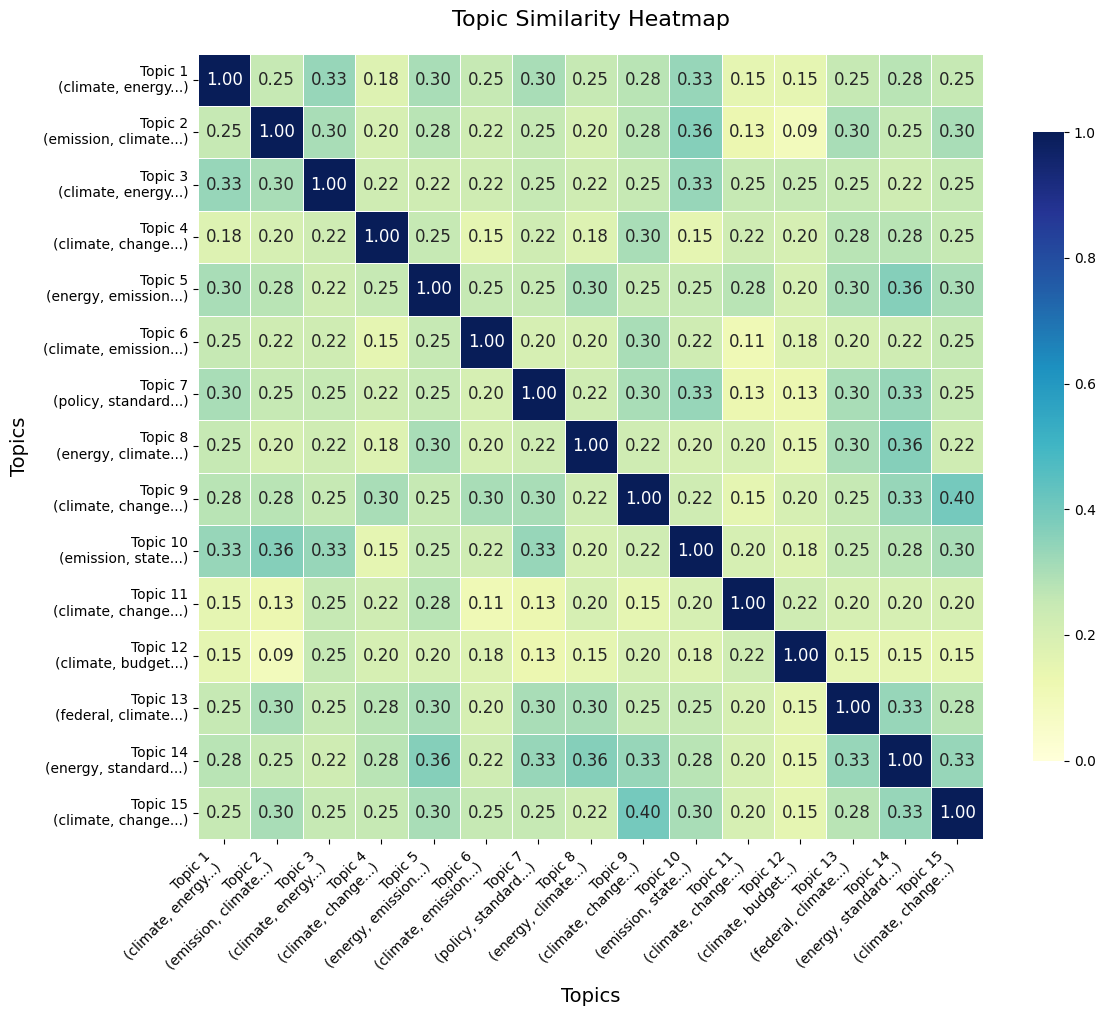

In [12]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create heatmap with improved aesthetics
sns.heatmap(similarity_scores, 
            annot=True, 
            cmap="YlGnBu", 
            vmin=0, 
            vmax=1, 
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8},
            fmt=".2f",
            annot_kws={"size": 12})

# Customize the plot
plt.title("Topic Similarity Heatmap", fontsize=16, pad=20)
plt.xlabel("Topics", fontsize=14, labelpad=10)
plt.ylabel("Topics", fontsize=14, labelpad=10)

# Add topic labels with more descriptive names
topic_labels = [f"Topic {i+1}\n({', '.join(topics_[i][:2])}...)" for i in range(len(topics_))]
plt.xticks(np.arange(len(topics_)) + 0.5, topic_labels, rotation=45, ha='right', fontsize=10)
plt.yticks(np.arange(len(topics_)) + 0.5, topic_labels, rotation=0, va='center', fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [13]:
df = pd.DataFrame()
for i, topic in enumerate(topics):
    words = topic[1].split("+")
    topic_words = [word.split("*")[1].replace('"', '').strip() for word in words]
    topic_weights = [float(word.split("*")[0]) for word in words]
    df[f"Topic_{i}"] = topic_words
    df[f"Topic_{i}_weights"] = topic_weights

In [14]:
# df = df[[f"Topic_{i}" for i in range(len(topics))] + [f"Topic_{i}_weights" for i in range(len(topics))]]
new_ordering = []
for i in range(len(topics)):
    new_ordering.append(f"Topic_{i}")
    new_ordering.append(f"Topic_{i}_weights")

df = df[new_ordering]

In [15]:
df.to_csv("topics_US.csv", index=False)

#### Inference

In [16]:
# For each doc in documents split the text into sentences and find topic distribution for each sentence
tokenizer = RegexpTokenizer(r'\w+')

# Split the documents into sentences
sentences = [sent_tokenize(doc) for doc in documents]
doc_sentences = [[None] * len(sentences[idx]) for idx in range(len(sentences))]

for idx in range(len(sentences)):
    for ind in range(len(sentences[idx])):
        # Remove links -> convert to lowercase -> remove non-alphanumeric characters -> tokenize
        sentence = re.sub(r'http\S+|www.\S+', '', sentences[idx][ind])
        sentence = tokenizer.tokenize(re.sub(r'\W', ' ', sentence.lower()))
        # Remove numbers, but not words that contain numbers.
        sentence = [token for token in sentence if not token.isnumeric()]
        # Remove words that are only one character.
        sentence = [token for token in sentence if len(token) > 1]
        # Remove stopwords
        sentence = [token for token in sentence if token not in stopwords.words('english')]

        # Store in doc_sentences
        doc_sentences[idx][ind] = sentence

# Remove empty sentences & Create a version of sentences where the sentences corresponding to the empty sentences are removed
# Initialize new lists
filtered_doc_sentences = []
filtered_sentences = []

# Iterate over each document
for doc_idx, doc in enumerate(doc_sentences):
    temp_doc = []
    temp_sent = []
    for sent_idx, sentence in enumerate(doc):
        # If the sentence is not empty, add it to the temporary lists
        if sentence:
            temp_doc.append(sentence)
            temp_sent.append(sentences[doc_idx][sent_idx])
    # Add the temporary lists to the new lists
    filtered_doc_sentences.append(temp_doc)
    filtered_sentences.append(temp_sent)

In [17]:
# Lemmatize the tokens
lemmatizer = WordNetLemmatizer()
filtered_doc_sentences = [[[lemmatizer.lemmatize(token) for token in ls] for ls in doc] for doc in filtered_doc_sentences]

In [18]:
sentence_bow = [[dictionary.doc2bow(sentence) for sentence in doc] for doc in filtered_doc_sentences]
topic_distribution = [[model.get_document_topics(sentence) for sentence in doc] for doc in sentence_bow]

In [19]:
import pandas as pd
df = pd.DataFrame()

doc_country_map = {0: 'US', 2: 'UK', 1: 'IN'}

num_topics = len(topics_)
for i in range(len(topic_distribution)):
    for dist, sentence in zip(topic_distribution[i], filtered_sentences[i]):
        dist_dict = dict(dist)
        dist_dict['Sentence'] = sentence
        dist_dict['Doc_ID'] = doc_country_map[i]
        df_ = pd.DataFrame([dist_dict])
        df = pd.concat([df, df_], ignore_index=True)

df.rename(columns={i: f'Topic_{i}' for i in range(num_topics)}, inplace=True)
df = df[['Doc_ID', 'Sentence'] + [f'Topic_{i}' for i in range(num_topics)]]


In [20]:
# Compute mean and standard deviation for each topic (for each topic, across all documents)

# Compute mean for each topic
topic_means = df[[f'Topic_{i}' for i in range(num_topics)]].mean()

# Compute standard deviation for each topic
topic_stds = df[[f'Topic_{i}' for i in range(num_topics)]].std()

print("Topic Means: \n", topic_means)
print("Topic Standard Deviations: \n", topic_stds)

Topic Means: 
 Topic_0     0.216806
Topic_1     0.240729
Topic_2     0.245932
Topic_3     0.245362
Topic_4     0.306920
Topic_5     0.249069
Topic_6     0.224430
Topic_7     0.250942
Topic_8     0.345843
Topic_9     0.235255
Topic_10    0.243205
Topic_11    0.345062
Topic_12    0.306416
Topic_13    0.279011
Topic_14    0.287327
dtype: float32
Topic Standard Deviations: 
 Topic_0     0.347047
Topic_1     0.363226
Topic_2     0.376087
Topic_3     0.362633
Topic_4     0.388353
Topic_5     0.364065
Topic_6     0.355458
Topic_7     0.373339
Topic_8     0.397401
Topic_9     0.366725
Topic_10    0.367887
Topic_11    0.387467
Topic_12    0.394908
Topic_13    0.389165
Topic_14    0.388238
dtype: float32


In [21]:
# Replace NaN values with 0
df.fillna(0, inplace=True)

In [22]:
# Compute mean for each topic
topic_means = df[[f'Topic_{i}' for i in range(num_topics)]].mean()

for i in range(num_topics):
    df[f'TS_{i}'] = df[f'Topic_{i}'].apply(lambda x: 1 if x >= topic_means[f'Topic_{i}'] else 0)

In [23]:
# Create a new column 'Sentence_ID' where each sentence in a document gets a unique ID
df['Sentence_ID'] = df.groupby('Doc_ID').cumcount() + 1

# Update 'Sentence_ID' to include 'Doc_ID'
df['Sentence_ID'] = df['Doc_ID'] + '_' + df['Sentence_ID'].astype(str)

In [24]:
df = df[['Doc_ID', 'Sentence_ID', 'Sentence'] + [f'Topic_{i}' for i in range(num_topics)] + [f'TS_{i}' for i in range(num_topics)]]

In [25]:
df.to_csv('topic_modeling_results_IN.csv', index=False)

In [26]:
df

,Doc_ID,Sentence_ID,Sentence,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,...,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11,TS_12,TS_13,TS_14
0,US,US_1,"Climate Change Policy \nOctober 28, 2021 \nC...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
1,US,US_2,Climate Change Policy \nThe greenhouse gases ...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
2,US,US_3,Scientific assessments conclude that GHGs very...,0.000000,0.928193,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,US,US_4,The most recent global assessment \nprojected ...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
4,US,US_5,A range of actions to mitigate GHG emissions \...,0.000000,0.000000,0.000000,0.000000,0.000000,0.967811,0.000000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,US,US_832,It operates solely at the behest of and \nunde...,0.011113,0.011113,0.011113,0.011113,0.011113,0.011113,0.011113,...,0,0,0,0,0,0,1,0,0,0
832,US,US_833,Information in a CRS Report should n ot be rel...,0.000000,0.000000,0.000000,0.000000,0.950871,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
833,US,US_834,"CRS Reports, as a work of the United States Go...",0.000000,0.000000,0.928199,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
834,US,US_835,Any CRS Report may be reproduced and distribut...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,0


#### Better Context Generation

In [53]:
def filter_and_sort(df: pd.DataFrame, topic_id: int, threshold: float = 0.5):
    # Filter the dataframe based on the threshold
    df_ = df[df[f'Topic_{topic_id}'] >= threshold]

    return df_

def group_and_fill(df_full: pd.DataFrame, df_filtered: pd.DataFrame, topic_id: int, threshold: int = 5):
    # Get the indices of the filtered dataframe
    indices = df_filtered.index.tolist()

    # Fill intermediate indices based on the threshold
    for i in range(len(indices)-1):
        if indices[i+1] - indices[i] <= threshold:
            df_filtered = pd.concat([df_filtered, df_full.iloc[indices[i]+1:indices[i+1]]])
    
    df_filtered = df_filtered.sort_index()
    return df_filtered

def get_better_context(df: pd.DataFrame, topic_id: int, filter_threshold: float = 0.5, group_threshold: int = 5):
    df_filtered = filter_and_sort(df, topic_id)
    df_grouped = group_and_fill(df, df_filtered, topic_id)

    context = df_grouped['Sentence'].tolist()

    return df_grouped, '\n\n'.join(context)


    

In [54]:
df_grouped, context = get_better_context(df, 0, group_threshold=10)

In [55]:
print(context)

Climate Policy  
Historically, the  United States has demonstrated varying  approa ches and intent with regard to 
addressing climate change generally and to participating in GHG abatement under the 1992 
United Nations Framework Convention on Climate Change (UNFCCC).

Legislative 
proposals have included carbon pricing frameworks (e.g., carbon taxes or cap -and-trade programs), sectoral approaches such 
as a clean energy  standard, research funding or tax policies that support GHG -abating technology development and 
deployment, efforts to increase adaptation, and international cooperation.

A range of actions that seek to  reduce GHG emissions are currently under  way or being 
developed by international  and subnational entities  (e.g.,  financing by multilateral development 
banks, or U.S. state actions or regional partnerships), as well as by the U.S. federal government 
(e.g.,  support for carbon capture technologies).

Upcoming international discussions, strongly held public opi